## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [40]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2019-11-04 09:32:06--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.105.125
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.105.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.2’

train-test-data.zip 100%[===================>] 322.93M  10.6MB/s    in 9.0s    

2019-11-04 09:32:15 (35.9 MB/s) - ‘/data/train-test-data.zip.2’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [41]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv_drop): Dropout(p=0.2)
  (fc_drop): Dropout(p=0.3)
  (fc1): Linear(in_features=43264, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [43]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()
])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [44]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [45]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [46]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [47]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [48]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [49]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [50]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

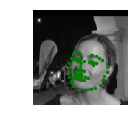

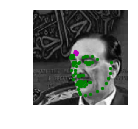

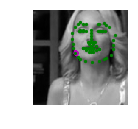

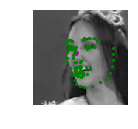

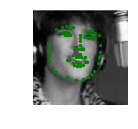

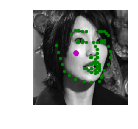

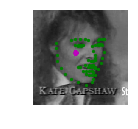

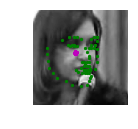

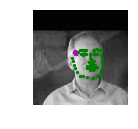

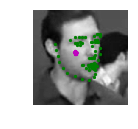

In [51]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [57]:
## TODO: Define the loss and optimization
import torch.optim as optim

#criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
#criterion = nn.L1Loss()

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [58]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [59]:
net.load_state_dict(torch.load('saved_models/keypoints_model_1_MSE1000_6d.pt'))

In [65]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.05304987970739603
Epoch: 1, Batch: 20, Avg. Loss: 0.03191392533481121
Epoch: 1, Batch: 30, Avg. Loss: 0.032404151186347006
Epoch: 1, Batch: 40, Avg. Loss: 0.0304631382226944
Epoch: 1, Batch: 50, Avg. Loss: 0.03367775734513998
Epoch: 1, Batch: 60, Avg. Loss: 0.035323856957256795
Epoch: 1, Batch: 70, Avg. Loss: 0.038130993396043776
Epoch: 1, Batch: 80, Avg. Loss: 0.029125776793807744
Epoch: 1, Batch: 90, Avg. Loss: 0.04187535224482417
Epoch: 1, Batch: 100, Avg. Loss: 0.03456707578152418
Epoch: 1, Batch: 110, Avg. Loss: 0.038676828239113094
Epoch: 1, Batch: 120, Avg. Loss: 0.04254380594938993
Epoch: 1, Batch: 130, Avg. Loss: 0.03494486715644598
Epoch: 1, Batch: 140, Avg. Loss: 0.026332829799503087
Epoch: 1, Batch: 150, Avg. Loss: 0.02772760931402445
Epoch: 1, Batch: 160, Avg. Loss: 0.02937255185097456
Epoch: 1, Batch: 170, Avg. Loss: 0.03596365824341774
Epoch: 1, Batch: 180, Avg. Loss: 0.034211131278425455
Epoch: 1, Batch: 190, Avg. Loss: 0.03550530914217

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.05930880289524794
Epoch: 2, Batch: 20, Avg. Loss: 0.033718557469546794
Epoch: 2, Batch: 30, Avg. Loss: 0.03247600272297859
Epoch: 2, Batch: 40, Avg. Loss: 0.028119021095335484
Epoch: 2, Batch: 50, Avg. Loss: 0.03722001928836107
Epoch: 2, Batch: 60, Avg. Loss: 0.03219032846391201
Epoch: 2, Batch: 70, Avg. Loss: 0.03792941402643919
Epoch: 2, Batch: 80, Avg. Loss: 0.029260789416730403
Epoch: 2, Batch: 90, Avg. Loss: 0.040361377596855166
Epoch: 2, Batch: 100, Avg. Loss: 0.03028020728379488
Epoch: 2, Batch: 110, Avg. Loss: 0.041113972663879395
Epoch: 2, Batch: 120, Avg. Loss: 0.02895324919372797
Epoch: 2, Batch: 130, Avg. Loss: 0.032322063110768795
Epoch: 2, Batch: 140, Avg. Loss: 0.03557356260716915
Epoch: 2, Batch: 150, Avg. Loss: 0.03435685569420457
Epoch: 2, Batch: 160, Avg. Loss: 0.026120523735880852
Epoch: 2, Batch: 170, Avg. Loss: 0.03300025649368763
Epoch: 2, Batch: 180, Avg. Loss: 0.03236568244174123
Epoch: 2, Batch: 190, Avg. Loss: 0.0347915284335

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.03125533070415258
Epoch: 3, Batch: 20, Avg. Loss: 0.0380620101466775
Epoch: 3, Batch: 30, Avg. Loss: 0.05074627920985222
Epoch: 3, Batch: 40, Avg. Loss: 0.03248287495225668
Epoch: 3, Batch: 50, Avg. Loss: 0.04269623961299658
Epoch: 3, Batch: 60, Avg. Loss: 0.050375413056463
Epoch: 3, Batch: 70, Avg. Loss: 0.03706905618309975
Epoch: 3, Batch: 80, Avg. Loss: 0.029051812645047904
Epoch: 3, Batch: 90, Avg. Loss: 0.04578154366463423
Epoch: 3, Batch: 100, Avg. Loss: 0.027780900709331036
Epoch: 3, Batch: 110, Avg. Loss: 0.03505817614495754
Epoch: 3, Batch: 120, Avg. Loss: 0.03533494248986244
Epoch: 3, Batch: 130, Avg. Loss: 0.028235889598727228
Epoch: 3, Batch: 140, Avg. Loss: 0.04282717667520046
Epoch: 3, Batch: 150, Avg. Loss: 0.02979855090379715
Epoch: 3, Batch: 160, Avg. Loss: 0.04168752888217568
Epoch: 3, Batch: 170, Avg. Loss: 0.029814629815518856
Epoch: 3, Batch: 180, Avg. Loss: 0.029217368736863137
Epoch: 3, Batch: 190, Avg. Loss: 0.035022911801934245

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.03532082457095385
Epoch: 4, Batch: 20, Avg. Loss: 0.04445648398250342
Epoch: 4, Batch: 30, Avg. Loss: 0.041359268687665464
Epoch: 4, Batch: 40, Avg. Loss: 0.036042929999530314
Epoch: 4, Batch: 50, Avg. Loss: 0.03148120753467083
Epoch: 4, Batch: 60, Avg. Loss: 0.0457800667732954
Epoch: 4, Batch: 70, Avg. Loss: 0.029676322359591722
Epoch: 4, Batch: 80, Avg. Loss: 0.05206776950508356
Epoch: 4, Batch: 90, Avg. Loss: 0.034569644741714
Epoch: 4, Batch: 100, Avg. Loss: 0.03526433799415827
Epoch: 4, Batch: 110, Avg. Loss: 0.027689509838819504
Epoch: 4, Batch: 120, Avg. Loss: 0.03396288901567459
Epoch: 4, Batch: 130, Avg. Loss: 0.029340908396989107
Epoch: 4, Batch: 140, Avg. Loss: 0.028619210608303546
Epoch: 4, Batch: 150, Avg. Loss: 0.029535324312746525
Epoch: 4, Batch: 160, Avg. Loss: 0.03434383999556303
Epoch: 4, Batch: 170, Avg. Loss: 0.025829134695231914
Epoch: 4, Batch: 180, Avg. Loss: 0.0217746558599174
Epoch: 4, Batch: 190, Avg. Loss: 0.0390042771585285

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.03023210437968373
Epoch: 5, Batch: 20, Avg. Loss: 0.04312616139650345
Epoch: 5, Batch: 30, Avg. Loss: 0.02501238211989403
Epoch: 5, Batch: 40, Avg. Loss: 0.030761175323277712
Epoch: 5, Batch: 50, Avg. Loss: 0.04087116997689009
Epoch: 5, Batch: 60, Avg. Loss: 0.03267332799732685
Epoch: 5, Batch: 70, Avg. Loss: 0.0354446324519813
Epoch: 5, Batch: 80, Avg. Loss: 0.04775645546615124
Epoch: 5, Batch: 90, Avg. Loss: 0.037233584001660346
Epoch: 5, Batch: 100, Avg. Loss: 0.03480602949857712
Epoch: 5, Batch: 110, Avg. Loss: 0.027388122770935296
Epoch: 5, Batch: 120, Avg. Loss: 0.03199684303253889
Epoch: 5, Batch: 130, Avg. Loss: 0.03143815118819475
Epoch: 5, Batch: 140, Avg. Loss: 0.0350901385769248
Epoch: 5, Batch: 150, Avg. Loss: 0.03295873003080487
Epoch: 5, Batch: 160, Avg. Loss: 0.02959591569378972
Epoch: 5, Batch: 170, Avg. Loss: 0.03534062840044498
Epoch: 5, Batch: 180, Avg. Loss: 0.02751548457890749
Epoch: 5, Batch: 190, Avg. Loss: 0.027355273999273778


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.033389199338853356
Epoch: 6, Batch: 20, Avg. Loss: 0.0399416359141469
Epoch: 6, Batch: 30, Avg. Loss: 0.027910482697188856
Epoch: 6, Batch: 40, Avg. Loss: 0.05980691015720367
Epoch: 6, Batch: 50, Avg. Loss: 0.0430957306176424
Epoch: 6, Batch: 60, Avg. Loss: 0.05103963958099485
Epoch: 6, Batch: 70, Avg. Loss: 0.030279132910072802
Epoch: 6, Batch: 80, Avg. Loss: 0.03207468409091234
Epoch: 6, Batch: 90, Avg. Loss: 0.044696489721536635
Epoch: 6, Batch: 100, Avg. Loss: 0.0330710431560874
Epoch: 6, Batch: 110, Avg. Loss: 0.04808251615613699
Epoch: 6, Batch: 120, Avg. Loss: 0.037742426991462706
Epoch: 6, Batch: 130, Avg. Loss: 0.03484583031386137
Epoch: 6, Batch: 140, Avg. Loss: 0.040789085626602176
Epoch: 6, Batch: 150, Avg. Loss: 0.04587866012006998
Epoch: 6, Batch: 160, Avg. Loss: 0.04114711862057448
Epoch: 6, Batch: 170, Avg. Loss: 0.03430240154266358
Epoch: 6, Batch: 180, Avg. Loss: 0.029321794398128986
Epoch: 6, Batch: 190, Avg. Loss: 0.0312091911211609

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.03067802917212248
Epoch: 7, Batch: 20, Avg. Loss: 0.03904672376811504
Epoch: 7, Batch: 30, Avg. Loss: 0.04578354377299547
Epoch: 7, Batch: 40, Avg. Loss: 0.033360347524285315
Epoch: 7, Batch: 50, Avg. Loss: 0.034261582978069784
Epoch: 7, Batch: 60, Avg. Loss: 0.03515414856374264
Epoch: 7, Batch: 70, Avg. Loss: 0.04287007432430982
Epoch: 7, Batch: 80, Avg. Loss: 0.042313354834914205
Epoch: 7, Batch: 90, Avg. Loss: 0.02959025138989091
Epoch: 7, Batch: 100, Avg. Loss: 0.05831385646015406
Epoch: 7, Batch: 110, Avg. Loss: 0.031121030636131763
Epoch: 7, Batch: 120, Avg. Loss: 0.033607561886310575
Epoch: 7, Batch: 130, Avg. Loss: 0.04433976449072361
Epoch: 7, Batch: 140, Avg. Loss: 0.05761255528777838
Epoch: 7, Batch: 150, Avg. Loss: 0.03072378467768431
Epoch: 7, Batch: 160, Avg. Loss: 0.04050056394189596
Epoch: 7, Batch: 170, Avg. Loss: 0.035047531872987744
Epoch: 7, Batch: 180, Avg. Loss: 0.038708881475031376
Epoch: 7, Batch: 190, Avg. Loss: 0.0291823879815

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.03646841384470463
Epoch: 8, Batch: 20, Avg. Loss: 0.03597266748547554
Epoch: 8, Batch: 30, Avg. Loss: 0.02990786135196686
Epoch: 8, Batch: 40, Avg. Loss: 0.028029898647218943
Epoch: 8, Batch: 50, Avg. Loss: 0.040711482614278795
Epoch: 8, Batch: 60, Avg. Loss: 0.03359120581299067
Epoch: 8, Batch: 70, Avg. Loss: 0.02775665409862995
Epoch: 8, Batch: 80, Avg. Loss: 0.04214268289506436
Epoch: 8, Batch: 90, Avg. Loss: 0.02933120122179389
Epoch: 8, Batch: 100, Avg. Loss: 0.02353922389447689
Epoch: 8, Batch: 110, Avg. Loss: 0.06170432418584824
Epoch: 8, Batch: 120, Avg. Loss: 0.02929240446537733
Epoch: 8, Batch: 130, Avg. Loss: 0.04190764985978603
Epoch: 8, Batch: 140, Avg. Loss: 0.02589153600856662
Epoch: 8, Batch: 150, Avg. Loss: 0.027278352808207274
Epoch: 8, Batch: 160, Avg. Loss: 0.03494203481823206
Epoch: 8, Batch: 170, Avg. Loss: 0.03161266315728426
Epoch: 8, Batch: 180, Avg. Loss: 0.06218740977346897
Epoch: 8, Batch: 190, Avg. Loss: 0.04060818757861852

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.02954643089324236
Epoch: 9, Batch: 20, Avg. Loss: 0.043228333629667756
Epoch: 9, Batch: 30, Avg. Loss: 0.02739409785717726
Epoch: 9, Batch: 40, Avg. Loss: 0.03566063214093447
Epoch: 9, Batch: 50, Avg. Loss: 0.03457974549382925
Epoch: 9, Batch: 60, Avg. Loss: 0.03319940064102411
Epoch: 9, Batch: 70, Avg. Loss: 0.04630372300744057
Epoch: 9, Batch: 80, Avg. Loss: 0.04381955973803997
Epoch: 9, Batch: 90, Avg. Loss: 0.03672448024153709
Epoch: 9, Batch: 100, Avg. Loss: 0.04023092221468687
Epoch: 9, Batch: 110, Avg. Loss: 0.037461902014911175
Epoch: 9, Batch: 120, Avg. Loss: 0.02797758337110281
Epoch: 9, Batch: 130, Avg. Loss: 0.04682327564805746
Epoch: 9, Batch: 140, Avg. Loss: 0.0335693309083581
Epoch: 9, Batch: 150, Avg. Loss: 0.04272684250026941
Epoch: 9, Batch: 160, Avg. Loss: 0.03915838431566954
Epoch: 9, Batch: 170, Avg. Loss: 0.03068729992955923
Epoch: 9, Batch: 180, Avg. Loss: 0.029145299270749093
Epoch: 9, Batch: 190, Avg. Loss: 0.05012357551604509


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.04677396882325411
Epoch: 10, Batch: 20, Avg. Loss: 0.03191196024417877
Epoch: 10, Batch: 30, Avg. Loss: 0.027994506526738405
Epoch: 10, Batch: 40, Avg. Loss: 0.030091395229101182
Epoch: 10, Batch: 50, Avg. Loss: 0.03595289457589388
Epoch: 10, Batch: 60, Avg. Loss: 0.03657187353819609
Epoch: 10, Batch: 70, Avg. Loss: 0.03372344421222806
Epoch: 10, Batch: 80, Avg. Loss: 0.02742710467427969
Epoch: 10, Batch: 90, Avg. Loss: 0.046853041462600234
Epoch: 10, Batch: 100, Avg. Loss: 0.05228571435436606
Epoch: 10, Batch: 110, Avg. Loss: 0.028205779381096363
Epoch: 10, Batch: 120, Avg. Loss: 0.03859157795086503
Epoch: 10, Batch: 130, Avg. Loss: 0.06200981605798006
Epoch: 10, Batch: 140, Avg. Loss: 0.0278665816411376
Epoch: 10, Batch: 150, Avg. Loss: 0.031177718844264745
Epoch: 10, Batch: 160, Avg. Loss: 0.029132013395428657
Epoch: 10, Batch: 170, Avg. Loss: 0.02518754005432129
Epoch: 10, Batch: 180, Avg. Loss: 0.04473522081971169
Epoch: 10, Batch: 190, Avg. Loss

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [66]:
#net.load_state_dict(torch.load('saved_models/keypoints_model_1_MSE1000_3.pt'))

In [67]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


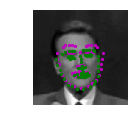

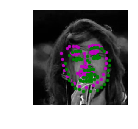

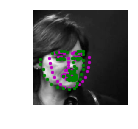

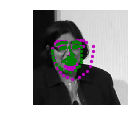

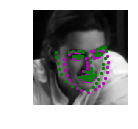

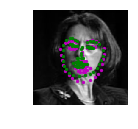

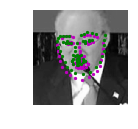

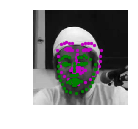

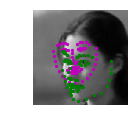

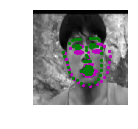

In [68]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [69]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1_MSE1000_6f.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?

After testing and reading about that I see that SmoothL1Loss (in my case I obtained better results  than with  MSELoss) and Adam are aceptable optimization and Loss functions. I had a lot of problems with desconnections of udacity server so I had no opportunity to lunch largest number of epochs. Playing with momentum and Learning rate I see that 

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

I started witt CNN network with 128 neurons, after few layers 32 -> 64 -> 128 and finally 256 neurons. and full conect layers at the end. After tests I saw that more complex structures are'nt best. So I try make more easy structure with less  neurons at strat 16 -> 32 -> 64 only and flat fc ant the end.

Final network is 
```
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_drop): Dropout(p=0.2)
  (fc1): Linear(in_features=43264, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.3)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.3)
  (fc3): Linear(in_features=1024, out_features=136, bias=True)```
  
There is a possibility (or security) of better networks, but as I see the way is correct, and for testing problems I'm happy with results  


### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: When error is dropping I still training. When Errors go up it is sign of overfitting and I stop training - I see how much epochs is there. Loss is decreasing very slowly after 40 epochs, but I'm sure that there is no overfitting now. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.32375169 -0.3625387  -0.05888111]
 [-0.13720205 -0.08651608 -0.09124127]
 [-0.17385609 -0.22706439  0.18160675]]
(3, 3)


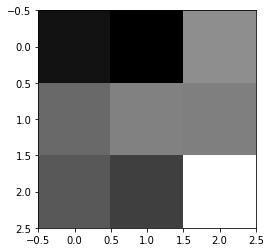

In [75]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


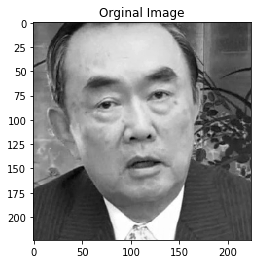

In [85]:
##TODO: load in and display any image from the transformed test dataset
# ..... transformed_dataset

img = transformed_dataset[143]['image'].squeeze()
plt.title("Orginal Image")
plt.imshow(img, cmap='gray')


#plt.imshow(image)
#plt.show() 
#plt.imshow(transformed_dataset[0])

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


[[-0.35585421  0.05227583 -0.28754613]
 [-0.56441385 -0.22029381 -0.0816948 ]
 [-0.1708871   0.22011884  0.14484274]]
(3, 3)


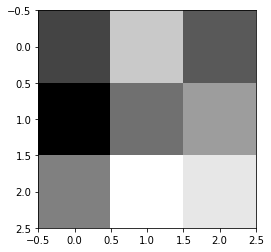

In [72]:
import cv2
iii = np.array(img)

w = weights1.numpy()

filter_index = 3

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights

plt.imshow(w[filter_index][0], cmap='gray')


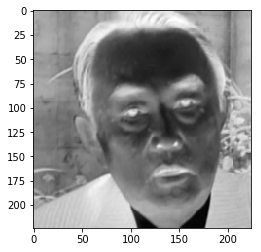

In [83]:
imgf = cv2.filter2D(iii, -1,w[filter_index][0])
plt.imshow(imgf, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: it detects dark areas like eyes and mounth inside face

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!